# Drought analysis

This notebook provides a comprehensive Discharge and Drought Analysis using historical, observed, and future simulated discharge data, with a central focus on characterizing discharge patterns and identifying drought behaviors across various hydrological scenarios. A key component of this analysis is the application of advanced statistical methods, particularly Metastatistical Extreme Value (MEV) analysis, which utilizes various extreme value distributions, including Weibull, Generalized Extreme Value (GEV), and Gumbel, to understand and predict extreme events like droughts.

In [57]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json
import math

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# For MEV
from scipy.stats import genextreme, gumbel_r, weibull_min

In [5]:
# Import drought classification functions
from critical_days_module import droughts, classify_discharge_status

Exported functions to: critical_days_module.py


In [6]:
# Load Data
#simulated
historic = pd.read_csv("Historic_discharge.csv", parse_dates=["date"], index_col="date")
future = pd.read_csv("Future_scenarios_discharge.csv", parse_dates=["date"], index_col="date")

#observed
# Manually parse the file
dates = []
discharges = []

with open("A3550050.csv", "r", encoding="utf-8") as f:
    next(f)
    for line in f:
        parts = line.replace('""', '"').strip().split(',"')
        if len(parts) >= 2:
            date_str = parts[0].strip('"')
            discharge_str = parts[1].strip('"')
            try:
                dates.append(pd.to_datetime(date_str))
                discharges.append(float(discharge_str))
            except ValueError:
                continue

discharge_series = pd.Series(discharges, index=dates, name="Observed")
xr_observed = xr.Dataset({"Observed": ("time", discharge_series.values)}, coords={"time": discharge_series.index})


In [7]:
# Convert to xarray
def df_to_xarray(df):
    return xr.Dataset({col: ("time", df[col].values) for col in df.columns}, coords={"time": df.index})

xr_historic = df_to_xarray(historic)
xr_future = df_to_xarray(future)

## Metastatistical Extreme Value (MEV) Analysis
The calculate_mev function within the notebook is specifically designed to perform Metastatistical Extreme Value (MEV) analysis. This analytical framework is generally employed to fit extreme value distributions to annual maximum (or minimum) data to gain an understanding of the behavior of rare, extreme events (Marra et al., 2018).

Unlike traditional extreme value theory methods, which often rely on the assumption of large samples from independent and identically distributed data, MEV offers a more flexible approach. It relaxes some of these stringent assumptions and exploits the full data record rather than just a small tail subsample. This makes MEV particularly valuable for estimating high quantiles (e.g., 100-year return period quantiles) from short records (as short as 5-20 years) with significantly reduced uncertainty, especially when a good model of ordinary events and an adequate number of events per year are available (Marra et al., 2018).

### Generalized Extreme Value (GEV) Distribution
The GEV distribution represents a family of continuous probability distributions that encompasses the Gumbel, Fréchet, and Weibull (specifically, reverse Weibull) families. It is widely used for modeling extreme events, such as maximum or minimum values observed in a series of observations. Traditional extreme value theory methods often assume that annual maxima series (AMS) asymptotically converge to the GEV distribution (Marra et al., 2018). It is also considered a popular alternative for extreme value estimation without any assumptions in some contexts (Wang et al., 2014).

The Cumulative Distribution Function (CDF) of the GEV distribution can be expressed as (Wang et al., 2014):

$$
F_G(z) = \exp \left( - \left[ 1 + \xi \left( \frac{z - \mu}{\sigma} \right) \right]^{-1/\xi} \right)
$$

Where:

- $z$ is the annual maximum discharge (in m³/s), derived from observed or simulated daily streamflow time series. One value per year is retained for GEV fitting.

- $\mu$ denotes the location parameter, representing the central tendency of annual maximum discharge.

- $\sigma$ denotes the scale parameter, indicating the spread or variability of annual maximum discharge values.

- $\xi$ denotes the shape parameter, which determines the tail behavior of the distribution:
    - $\xi > 0$: Fréchet type
    - $\xi = 0$: Gumbel type
    - $\xi < 0$: Reverse Weibull type

### Gumbel Distribution
The Gumbel distribution is a specific case of the GEV distribution ($\xi = 0$). It is frequently utilized for modeling the distribution of extreme values, particularly maximum values from a series of random variables (Wang et al., 2014).

The CDF of the Gumbel distribution can be defined as (Wang et al., 2014):

$$
F_1(v) = \exp \left( - \exp \left[ - \frac{(v - \mu)}{\sigma} \right] \right)
$$

Where:

- $F_1(v)$ is the cumulative probability of observing an annual maximum discharge less than or equal to $v$.

- $v$ represents the annual maximum discharge (in m³/s), derived from observed or simulated daily streamflow time series. One value per year is retained for fitting the distribution.

- $\mu$ denotes the location parameter, which reflects the central tendency of the annual maximum discharge values.

- $\sigma$ denotes the scale parameter, which represents the variability or spread of the annual maximum discharge values across different years.

### Weibull Distribution
The Weibull distribution plays a specific role within the MEV framework, primarily for modeling "ordinary events". The Weibull distribution is a versatile distribution often applied in reliability engineering and for modeling extreme values (Marra et al., 2018).

The Weibull cumulative distribution function can be written as (Marra et al., 2018): 

$$
F(y) = 1 - \exp \left( - \left( \frac{y}{\lambda} \right)^k \right)
$$

Where:

- $F(y)$ is the cumulative probability of observing a daily discharge less than or equal to $y$.

- $y$ represents the ordinary (non-extreme) daily discharge value in m³/s, drawn from the observed or simulated streamflow time series.

- $\lambda$ denotes the scale parameter, which determines the characteristic scale of daily discharge values — it stretches or compresses the distribution along the discharge axis.

- $k$ denotes the shape parameter, which controls the steepness of the distribution and reflects how concentrated or dispersed ordinary discharge values are.


In [8]:
# MEV functions
def calculate_mev(ds, dist_type='gev'):
    valid_ds = ds.dropna(dim="time", how="any")
    time_years = pd.to_datetime(valid_ds['time'].values).year
    years = np.unique(time_years)
    mev_distributions = {}

    for var in ds.data_vars:
        annual_params = []
        for year in years:
            mask = time_years == year
            values = valid_ds[var].values[mask]
            if len(values) > 0:
                if dist_type == 'gev': #GEV distribution
                    params = genextreme.fit(values)
                    dist_func = genextreme
                elif dist_type == 'gumbel': #Gumbel distribution
                    params = gumbel_r.fit(values)
                    dist_func = gumbel_r
                elif dist_type == 'weibull': #Weibull distribution
                    params = weibull_min.fit(values)
                    dist_func = weibull_min
                else:
                    raise ValueError("dist_type must be one of ['gev', 'gumbel', 'weibull']")
                annual_params.append(params)

        x_vals = np.linspace(np.min(valid_ds[var]), np.max(valid_ds[var]), 1000)
        cdfs = [dist_func.cdf(x_vals, *params) for params in annual_params]
        mean_cdf = np.mean(cdfs, axis=0)
        return_period = 1 / (1 - mean_cdf)

        mev_distributions[var] = (x_vals, return_period)

    mev_ds = xr.Dataset(
        {var: ("x", mev_distributions[var][1]) for var in mev_distributions},
        coords={"x": list(mev_distributions.values())[0][0]},
        attrs=ds.attrs
    )
    return mev_ds

In [9]:
def plot_mev(*mev_datasets, dist_type='gev', labels=None):
    plt.figure(figsize=(10, 6))
    
    for i, mev_ds in enumerate(mev_datasets):
        prefix = f"{labels[i]} - " if labels else ""
        for var in mev_ds.data_vars:
            plt.plot(mev_ds[var].values, mev_ds['x'].values, label=f"{prefix}{var}")
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Return Period (years)")
    plt.ylabel("Discharge (m³/s)")
    plt.axhline(y=500, color='red', linestyle='--', linewidth=1.2, label='500 m³/s threshold')
    plt.title(f"Metastatistical Extreme Value (MEV) Estimates - {dist_type.upper()} Fit")
    plt.ylim(bottom=300)  # Ensure y-axis starts from 300
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

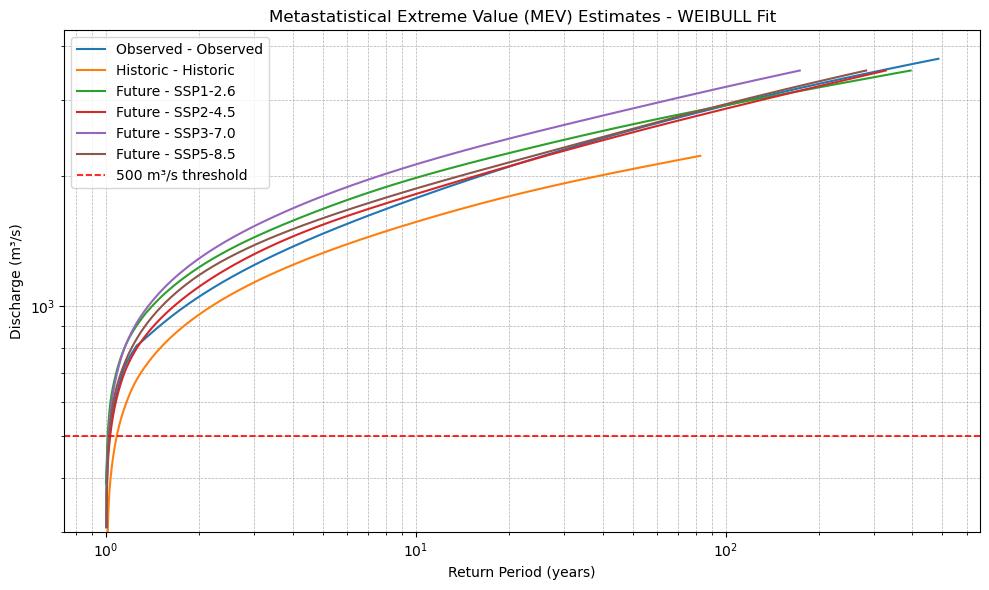

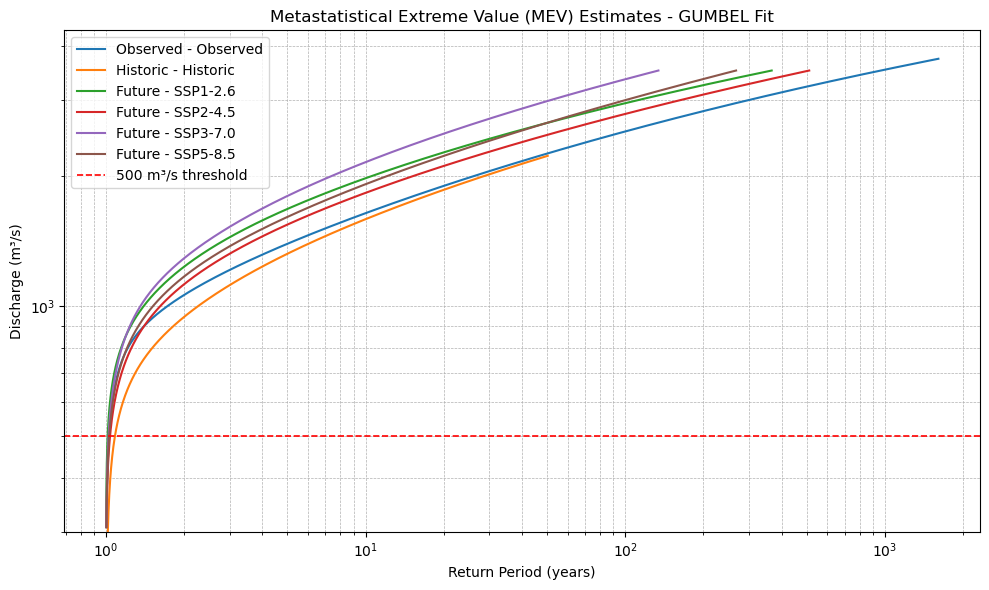

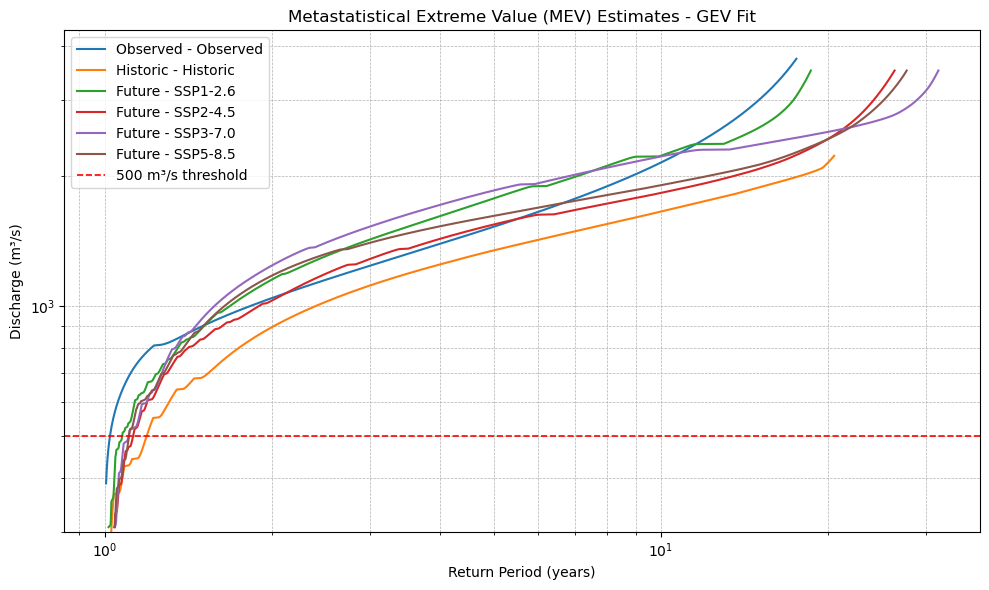

In [10]:
# Run MEV Analysis and Plot for all distributions
for dist in ['weibull', 'gumbel', 'gev']:
    xr_mev_obs = calculate_mev(xr_observed, dist_type=dist)
    xr_mev_hist = calculate_mev(xr_historic, dist_type=dist)
    xr_mev_fut = calculate_mev(xr_future, dist_type=dist)
    plot_mev(xr_mev_obs, xr_mev_hist, xr_mev_fut, dist_type=dist, labels=['Observed', 'Historic', 'Future'])


## Number of drought events by scenario

Please note that each scenario covers a different time span:

- **Observed:** 2013–2019  
- **Historic:** 1990–2014  
- **Future Scenarios:** 2026–2099  

In [78]:
#Input data & collect drought events
scenarios = {
    "Observed": discharge_series,
    "Historic": historic.iloc[:, 0],
    "SSP1-2.6": future.iloc[:, 0],
    "SSP2-4.5": future.iloc[:, 1],
    "SSP3-7.0": future.iloc[:, 2],
    "SSP5-8.5": future.iloc[:, 3]
}

all_dfs = []
for name, series in scenarios.items():
    df = droughts(series, basin_name=name, q_crit=500)
    df["Scenario"] = name
    all_dfs.append(df)
drought_events_df = pd.concat(all_dfs, ignore_index=True)

In [88]:
# Count raw events per Scenario & Status
raw_counts = (
    drought_events_df
    .groupby(["Scenario", "Status"])
    .size()
    .unstack(fill_value=0)
)

# Ensure all three categories exist (fill missing with 0)
raw_counts = raw_counts.reindex(columns=["caution", "risk", "critical"], fill_value=0)

In [89]:
#Compute time spans (years and n-year blocks)
years_info = {}
for name, series in scenarios.items():
    idx = getattr(series, "index", pd.DatetimeIndex(series))
    total_years = idx.max().year - idx.min().year + 1
    years_info[name] = total_years

years_df = (
    pd.Series(years_info, name="n_years")
      .to_frame()
      .reset_index()
      .rename(columns={"index": "Scenario"})
)
years_df["n_3yr_blocks"] = np.ceil(years_df["n_years"] / 3).astype(int)
years_df["n_10yr_blocks"] = np.ceil(years_df["n_years"] / 10).astype(int)
years_df["n_20yr_blocks"] = np.ceil(years_df["n_years"] / 20).astype(int)

In [90]:
#Merge & compute per-year and per-n-year rates
summary = raw_counts.reset_index().merge(years_df, on="Scenario", how="left")
for cat in ["caution", "risk", "critical"]:
    summary[f"{cat}_per_year"] = summary[cat] / summary["n_years"]
    summary[f"{cat}_per_3yrs"] = summary[cat] / summary["n_3yr_blocks"]
    summary[f"{cat}_per_10yrs"] = summary[cat] / summary["n_10yr_blocks"]
    summary[f"{cat}_per_20yrs"] = summary[cat] / summary["n_20yr_blocks"]

In [91]:
#Display summary tables
print("\nDroughts per year by scenario and category:\n")
display(summary[["Scenario", "caution_per_year", "risk_per_year", "critical_per_year"]])

print("\nDroughts per 3-year block by scenario and category:\n")
display(summary[[
    "Scenario", "n_years", "n_3yr_blocks",
    "caution_per_3yrs", "risk_per_3yrs", "critical_per_3yrs"
]])

print("\nDroughts per 10-year block by scenario and category:\n")
display(summary[[
    "Scenario", "n_years", "n_10yr_blocks",
    "caution_per_10yrs", "risk_per_10yrs", "critical_per_10yrs"
]])

print("\nDroughts per 20-year block by scenario and category:\n")
display(summary[[
    "Scenario", "n_years", "n_20yr_blocks",
    "caution_per_20yrs", "risk_per_20yrs", "critical_per_20yrs"
]])

Droughts per year by scenario and category:

,Scenario,caution_per_year,risk_per_year,critical_per_year
0,Historic,0.000000,0.125000,0.708333
1,Observed,0.714286,0.142857,0.285714
2,SSP1-2.6,0.013699,0.013699,0.136986
3,SSP2-4.5,0.027397,0.013699,0.273973
4,SSP3-7.0,0.000000,0.027397,0.219178
5,SSP5-8.5,0.000000,0.027397,0.219178


Droughts per 3-year block by scenario and category:

,Scenario,n_years,n_3yr_blocks,caution_per_3yrs,risk_per_3yrs,critical_per_3yrs
0,Historic,24,8,0.000000,0.375000,2.125000
1,Observed,7,3,1.666667,0.333333,0.666667
2,SSP1-2.6,73,25,0.040000,0.040000,0.400000
3,SSP2-4.5,73,25,0.080000,0.040000,0.800000
4,SSP3-7.0,73,25,0.000000,0.080000,0.640000
5,SSP5-8.5,73,25,0.000000,0.080000,0.640000


Droughts per 10-year block by scenario and category:

,Scenario,n_years,n_10yr_blocks,caution_per_10yrs,risk_per_10yrs,critical_per_10yrs
0,Historic,24,3,0.000,1.000,5.666667
1,Observed,7,1,5.000,1.000,2.000000
2,SSP1-2.6,73,8,0.125,0.125,1.250000
3,SSP2-4.5,73,8,0.250,0.125,2.500000
4,SSP3-7.0,73,8,0.000,0.250,2.000000
5,SSP5-8.5,73,8,0.000,0.250,2.000000


Droughts per 20-year block by scenario and category:

,Scenario,n_years,n_20yr_blocks,caution_per_20yrs,risk_per_20yrs,critical_per_20yrs
0,Historic,24,2,0.00,1.50,8.5
1,Observed,7,1,5.00,1.00,2.0
2,SSP1-2.6,73,4,0.25,0.25,2.5
3,SSP2-4.5,73,4,0.50,0.25,5.0
4,SSP3-7.0,73,4,0.00,0.50,4.0
5,SSP5-8.5,73,4,0.00,0.50,4.0


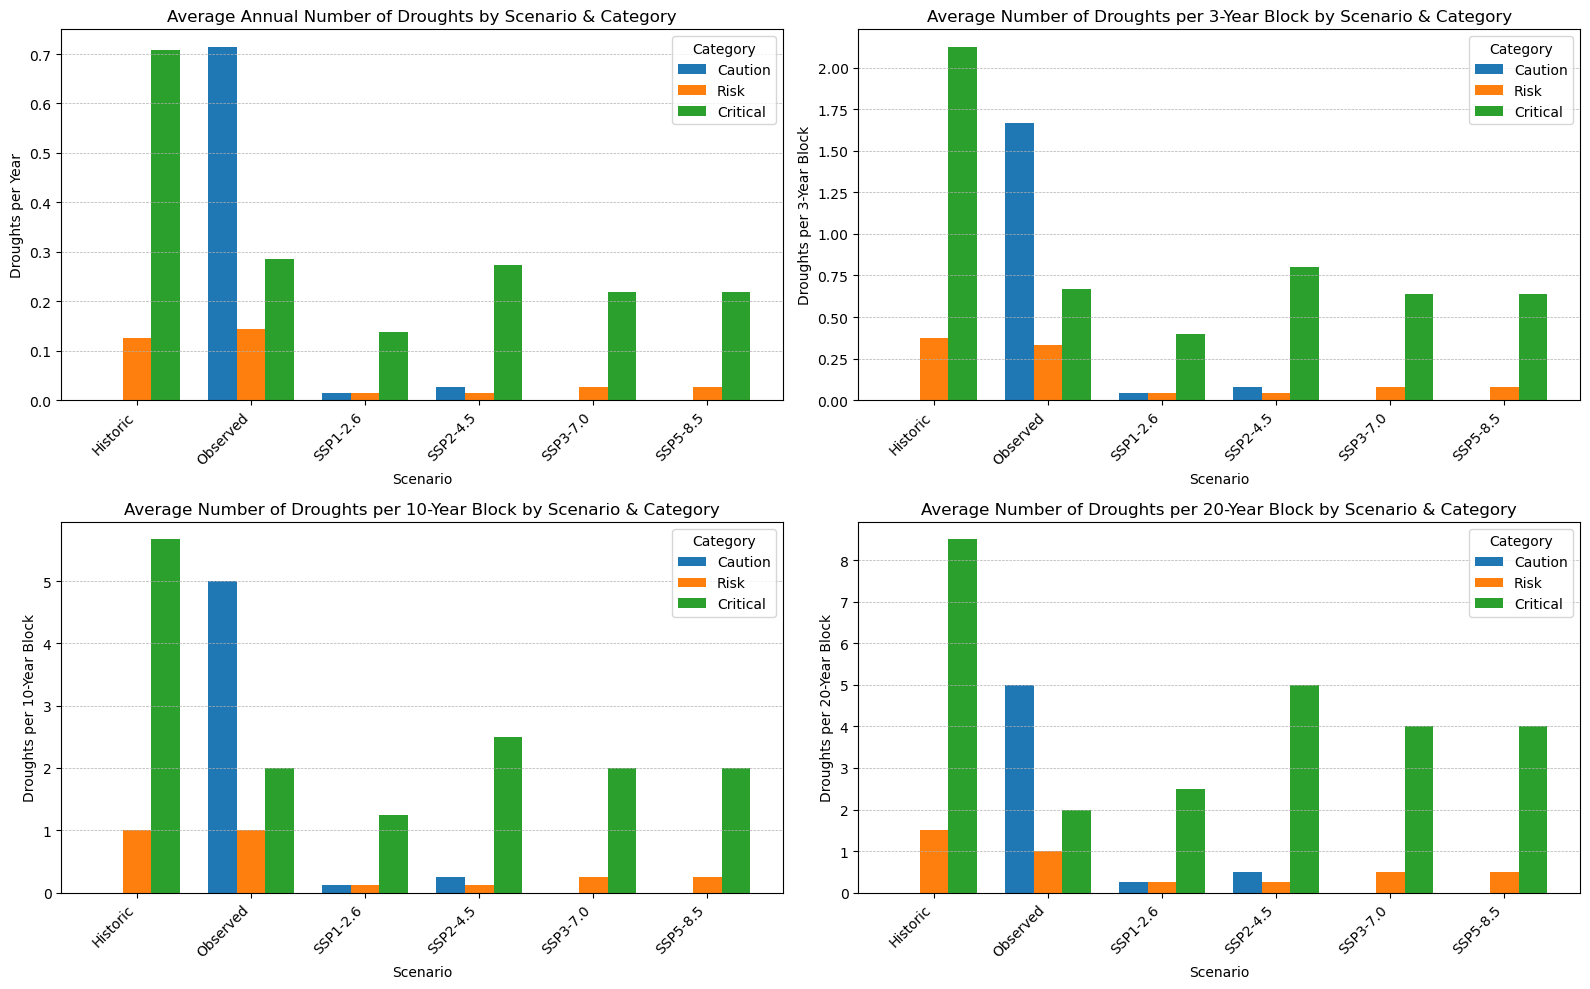

In [93]:
#Plot
plot_configs = [
    {
        "cols": ["caution_per_year", "risk_per_year", "critical_per_year"],
        "title": "Average Annual Number of Droughts by Scenario & Category",
        "ylabel": "Droughts per Year"
    },
    {
        "cols": ["caution_per_3yrs", "risk_per_3yrs", "critical_per_3yrs"],
        "title": "Average Number of Droughts per 3-Year Block by Scenario & Category",
        "ylabel": "Droughts per 3-Year Block"
    },
    {
        "cols": ["caution_per_10yrs", "risk_per_10yrs", "critical_per_10yrs"],
        "title": "Average Number of Droughts per 10-Year Block by Scenario & Category",
        "ylabel": "Droughts per 10-Year Block"
    },
    {
        "cols": ["caution_per_20yrs", "risk_per_20yrs", "critical_per_20yrs"],
        "title": "Average Number of Droughts per 20-Year Block by Scenario & Category",
        "ylabel": "Droughts per 20-Year Block"
    }
]

n = len(summary)
x = np.arange(n)
width = 0.25

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for ax, cfg in zip(axes, plot_configs):
    ax.bar(x - width, summary[cfg["cols"][0]], width, label="Caution")
    ax.bar(x        , summary[cfg["cols"][1]], width, label="Risk")
    ax.bar(x + width, summary[cfg["cols"][2]], width, label="Critical")

    ax.set_title(cfg["title"])
    ax.set_xlabel("Scenario")
    ax.set_ylabel(cfg["ylabel"])
    ax.set_xticks(x)
    ax.set_xticklabels(summary["Scenario"], rotation=45, ha="right")
    ax.legend(title="Category")
    ax.grid(True, axis="y", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()